In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml
from IPython.display import display

def fetch_titanic() -> tuple[pd.DataFrame, pd.DataFrame]:
    return fetch_openml("Titanic", version=1, return_X_y=True, as_frame=True)

X, y = fetch_titanic()

('pclass', 'age', 'fare', 'deck', 'fsize', 'sex_male')


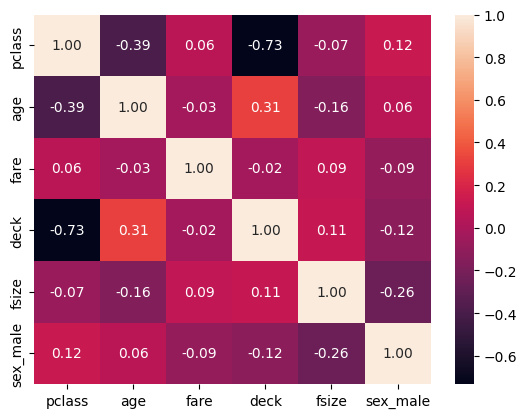

In [2]:
def fillna_age(X: pd.DataFrame):
    X = X.copy()
    title = X['name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

    title_age = X[['age']].join(title.rename('title'))
    title_age['title'] = title_age['title'].replace({
        'Mlle': 'Miss',
        'Ms': 'Miss',
        'Mme': 'Mrs'
    })
    title_age['title'] = title_age['title'].replace(
        ['Capt', 'Col', 'Countess', 'Don', 'Dona', 'Dr', 
        'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir'], 
        'Rare'
    )
    
    age_medians = title_age.groupby('title')['age'].median()
    age_map = title_age['title'].map(age_medians)
    X['age'] = X['age'].fillna(age_map)
    return X

def clean_data(X: pd.DataFrame):
    X = X.copy()
    X = fillna_age(X)
    
    X['deck'] = X['cabin'].fillna('U').str[0]
    X['deck'] = X['deck'].map(
        {'G': 1, 'F': 2, 'E': 3, 'D': 4, 
         'C': 5, 'B': 6, 'A': 7, 'T': 8}
    )
    
    # X['deck_unknown'] = X['deck'].isna()
    # X['deck'] = X['deck'].fillna(X['deck'].median()).astype(int)
    
    X['deck'] = X['deck'].fillna(0).astype(int)
    X['fare'] = X['fare'] != 0
    X['fsize'] = X['sibsp'] + X['parch'] + 1
    
    bins = [0, 1, 4, X['fsize'].max()]
    X['fsize'] = pd.cut(X['fsize'], bins=bins, labels=False, right=True)
    
    X = X.drop(['name', 'home.dest', 'cabin', 'ticket', 'body', 'boat', 'parch', 'sibsp'], axis=1)
    X = X.drop(['embarked'], axis=1)
    
    X = pd.get_dummies(X, columns=['sex'], drop_first=True)
    return X
83.2
import seaborn as sns
X_clean = clean_data(X)
sns.heatmap(X_clean.corr(), annot=True, fmt='.2f')
print(tuple(X_clean.columns))

In [3]:
def preprocess_data(X: pd.DataFrame, drop=[]):
    X = X.copy()
    X = X.drop(drop, axis=1)
    return X

display(preprocess_data(clean_data(X)).head())

,pclass,age,fare,deck,fsize,sex_male
0,1,29.0000,True,6,0,False
1,1,0.9167,True,5,1,True
2,1,2.0000,True,5,1,False
3,1,30.0000,True,5,1,True
4,1,25.0000,True,5,1,False


In [4]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.metrics import roc_auc_score, accuracy_score

from functools import partial

preprocessor = ColumnTransformer(transformers=[
    ('binner', KBinsDiscretizer(strategy='uniform', encode='ordinal', random_state=42), ['age']),
    ], remainder='passthrough'
)

prep_fn = partial(preprocess_data, drop=['deck'])
display(prep_fn(clean_data(X)).head())

model = Pipeline(steps=[
    ("cleaner", FunctionTransformer(clean_data)),
    ("preprocessor", FunctionTransformer(prep_fn)),
    ("age_binner", preprocessor),
    ("classifier", CategoricalNB(min_categories=[3, 25, 2, 4, 2]))
])

kf = StratifiedKFold(10, shuffle=True, random_state=42)
roc_auc = accuracy = 0.0

for train_idx, test_idx in kf.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    roc_auc += roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    accuracy += accuracy_score(y_test, model.predict(X_test))

print(f"ROC AUC: {roc_auc / 10:.2%}")
print(f"Accuracy: {accuracy / 10:.2%}")

,pclass,age,fare,fsize,sex_male
0,1,29.0000,True,0,False
1,1,0.9167,True,1,True
2,1,2.0000,True,1,False
3,1,30.0000,True,1,True
4,1,25.0000,True,1,False


ROC AUC: 82.82%
Accuracy: 78.92%


In [ ]:
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

param_grid = {
    'age_binner__binner__n_bins': [2, 5, 10, 25],
    'age_binner__binner__strategy': ['uniform', 'quantile', 'kmeans']
}

grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid,
    cv=StratifiedKFold(10, shuffle=True, random_state=42), 
    scoring='roc_auc', 
    n_jobs=-1,
)

with warnings.catch_warnings(action='ignore'):
    grid_search.fit(X, y)

df = pd.DataFrame(grid_search.cv_results_)
df = df.rename(columns={
    'param_age_binner__binner__n_bins': 'bins',
    'param_age_binner__binner__strategy': 'strategy',
    'mean_test_score': 'score'
})

df[['bins', 'strategy', 'score']].pivot(
    columns='bins', 
    index='strategy', 
    values='score'
).round(3) * 100

bins,2,5,10,25
strategy,,,,
kmeans,82.6,82.9,82.7,82.7
quantile,83.2,82.8,82.7,83.0
uniform,82.7,82.8,82.8,82.7
